In [1]:
import os

os.chdir("../../")

In [2]:
import re
from scripts.evaluate import answer_cleansing


def get_preds(pred, qsize=2):  
    if not pred:
        return False
    
    if isinstance(pred, str):
        pred = pred.strip()
        if len(pred) == 0:
            return False

    preds = []
    if pred[0] == ":" and len(pred) > 1:
        pred = pred[1:]
    
    if len(pred.split("\n\n")) == qsize:
        preds = pred.split("\n\n")
    
    elif len(pred.split("\n")) == qsize:
        preds = pred.split("\n")

    elif len(re.split(r"[QA]\d+: ?", pred)[1:]) == qsize:
        preds = re.split(r"[QA]\d+: ?", pred)[1:]
    
    if len(preds) != qsize:
        return False
    
    preds = [re.sub(r"[AQ]\d*:", "", p).strip() for p in preds]
    preds = [re.sub(r"Answer:", "", p, flags=re.I).strip() for p in preds]
    return preds

In [3]:
reasoning_benchmarks = [d for d in os.listdir("results/reasoning") if d not in [".DS_Store", "mixed"]]
reasoning_benchmarks

['commonsensqa',
 'strategyqa',
 'object_tracking',
 'last_letters',
 'coin_flip',
 'svamp',
 'bigbench_date',
 'gsm8k',
 'aqua',
 'singleeq',
 'addsub',
 'multiarith']

In [4]:
import pandas as pd


def safe_convert_to(dtype):
    def convert_to(value):
        try:
            return dtype(value)
        except:
            return value
    return convert_to


def read_reasoning_benchmark_results(benchmark, multi_question=False, 
                                     method="zero-shot"):
    if multi_question:
        input_fp = f"results/reasoning/{benchmark}/multiple question/{method}.json"
        df = pd.read_json(input_fp)
    else:
        input_fp = f"results/reasoning/{benchmark}/single question/{method}.csv"
        df = pd.read_csv(input_fp)
        df.insert(0, "promptIdx", df.index + 1)
        df.insert(2, "qsize", 1)
    return df

In [5]:
r_models = ['meta-llama/Llama-3-8b-chat-hf', 
            'meta-llama/Llama-3-70b-chat-hf', 
            'mistralai/Mistral-7B-Instruct-v0.2', 
            'mistralai/Mixtral-8x7B-Instruct-v0.1', 
            'lmsys/vicuna-13b-v1.5', 'gpt-3.5-turbo-0125']


def parse(pred, model, dataset, method="zero-shot", trigger="answer is"):      

    if "llama" in model:
        method = "few-shot"

        if dataset == "last_letters":
            pred_copy = pred

            pred = re.findall(r"[A-Z][A-Z -]+", pred)
            if pred:
                pred = re.sub(r"[^A-Z]", "", pred[-1]).lower()
            else:
                pred = pred_copy.split("\n")[-1]
                if ":" in pred:
                    pred = re.sub(r"[^:]+:", "", pred)
                    pred = re.sub(r"[^a-zA-Z]", "", pred).lower()
                else:
                    pred = pred_copy

    elif "mistralai" in model:
        if dataset in ["last_letters", "svamp", "gsm8k", "aqua", 
                       "singleeq", "addsub", "multiarith"]:
            method = "few-shot"
    elif model == "gpt-3.5-turbo-0125":
        if dataset == "gsm8k":
            method = "few-shot"
    elif model == "lmsys/vicuna-13b-v1.5":
        if dataset in ["svamp", "gsm8k", "aqua", "singleeq", "addsub", "multiarith"]:
            method = "few-shot"
    
    # sign of reasoning!
    if "=" in pred and ("+" in pred or "-" in pred or "*" in pred or "/" in pred):
        method = "few-shot"

    pred = answer_cleansing(pred, method, dataset, trigger)
    
    if pred == "":
        return "CANNOT_PARSE"
    return pred

In [6]:
parsed_results = []
cols = ["benchmark", "promptIdx", "prompt", "answer", "#shot", "CoT", 
        "qsize", "model", "completion", "parsed", "perTaskAccu"]

for benchmark in reasoning_benchmarks:
    for multi_question in [False, True]:
        df1 = read_reasoning_benchmark_results(benchmark, multi_question, "zero-shot")
        df1["CoT"] = False
        df2 = read_reasoning_benchmark_results(benchmark, multi_question, "zero-shot-cot")
        df2["CoT"] = True
        df = pd.concat([df1, df2]).reset_index(drop=True)
        
        for idx, row in df.iterrows():
            promptIdx = row["promptIdx"]
            prompt = row["prompt"]
            answer = row["answer"]
            qsize = row["qsize"]
            CoT = row["CoT"]
            method = "zero-shot-cot" if row["CoT"] else "zero-shot"

            if not CoT:
                models_all = r_models
            else:
                models_all = ["gpt-3.5-turbo-0125"]

            for model in models_all:
                completion = row[f"{model}-completion"]  

                try:
                    if qsize == 1:
                        parsed = parse(completion, model, benchmark, method)

                        if benchmark in ("gsm8k", "addsub", "multiarith", "svamp", "singleeq"):
                            parsed = safe_convert_to(float)(parsed)
                            answer = safe_convert_to(float)(answer)
                        
                        accu = float(parsed == answer)
                    
                    else:
                        preds = get_preds(completion, qsize)
                        if not preds:
                            parsed = "CANNOT_PARSE"
                            accu = 0.0
                        else:
                            parsed = [parse(p, model, benchmark, method) for p in preds]

                            if benchmark in ("gsm8k", "addsub", "multiarith", "svamp", "singleeq"):
                                parsed = [safe_convert_to(float)(p) for p in parsed]
                                answer = [safe_convert_to(float)(a) for a in answer]

                            accu = sum([float(a==p) for a, p in zip(answer, parsed)]) / qsize

                except Exception as e:
                    print(benchmark, model, promptIdx, qsize, e)
                    parsed = "CANNOT_PARSE"
                    accu = 0.0
                
                parsed_results.append([benchmark, promptIdx, prompt, answer, 0, CoT, 
                                       qsize, model, completion, parsed, accu])

commonsensqa mistralai/Mixtral-8x7B-Instruct-v0.1 895 1 argument of type 'float' is not iterable
bigbench_date gpt-3.5-turbo-0125 260 1 argument of type 'float' is not iterable
aqua gpt-3.5-turbo-0125 67 1 argument of type 'float' is not iterable


In [9]:
model_renamer = {"meta-llama/Llama-3-70b-chat-hf": "Llama-3 70B", "mistralai/Mixtral-8x7B-Instruct-v0.1": "Mixtral 8x7B", 
                "gpt-3.5-turbo-0125": "GPT-3.5", "meta-llama/Llama-3-8b-chat-hf": "Llama-3 8B", 
                "mistralai/Mistral-7B-Instruct-v0.2": "Mistral 7B", "gpt-4-turbo-2024-04-09": "GPT-4", 
                "lmsys/vicuna-13b-v1.5": "Vicuna 13B"}

cols = ["benchmark", "promptIdx", "prompt", "answer", "#shot", "CoT", 
        "qsize", "model", "completion", "parsed", "perTaskAccu"]

parsed_df = pd.DataFrame(parsed_results, columns=cols)
parsed_df.model = parsed_df.model.apply(lambda x: model_renamer[x])
parsed_df.head()

,benchmark,promptIdx,prompt,answer,#shot,CoT,qsize,model,completion,parsed,perTaskAccu
0,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Llama-3 8B,A clever question!\n\nThe correct answer is (E...,E,1.0
1,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Llama-3 70B,The correct answer is (E) dark.\n\nCandles are...,E,1.0
2,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Mistral 7B,(E) dark. Candles are commonly used to provid...,E,1.0
3,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Mixtral 8x7B,E: dark. Candles produce light and help to el...,E,1.0
4,commonsensqa,1,Q: What are candles good for eliminating?\nAns...,E,0,False,1,Vicuna 13B,(E) dark.\n\nCandles are often used to provid...,E,1.0


In [13]:
parsed_df[(parsed_df.benchmark == "coin_flip") & 
          (parsed_df.qsize == 2) & 
          (parsed_df.model == "Llama-3 8B")].parsed.apply(len).value_counts()

2     297
12      3
Name: parsed, dtype: int64

In [8]:
from IPython.display import display
from IPython.display import HTML

def check_answer(model, benchmark, qsize, CoT=False,
                 cols=["promptIdx", "prompt", "completion", 
                       "parsed", "answer", "perTaskAccu"], 
                 hide_prompt=True):
    
    if hide_prompt:
        cols = [c for c in cols if c != "prompt"]
    
    sub = parsed_df[(parsed_df.model == model) & 
                    (parsed_df.CoT == CoT) &
                    (parsed_df.benchmark == benchmark) & 
                    (parsed_df.qsize == qsize)][cols]
    return sub

def show_in_HTML(df):
    display(HTML(df.to_html().replace("\\n","<br>").strip()))    

In [9]:
print(reasoning_benchmarks)

['commonsensqa', 'strategyqa', 'object_tracking', 'last_letters', 'coin_flip', 'svamp', 'bigbench_date', 'gsm8k', 'aqua', 'singleeq', 'addsub', 'multiarith']


In [10]:
model_renamer

{'meta-llama/Llama-3-70b-chat-hf': 'Llama-3 70B',
 'mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral 8x7B',
 'gpt-3.5-turbo-0125': 'GPT-3.5',
 'meta-llama/Llama-3-8b-chat-hf': 'Llama-3 8B',
 'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral 7B',
 'gpt-4-turbo-2024-04-09': 'GPT-4',
 'lmsys/vicuna-13b-v1.5': 'Vicuna 13B'}

In [52]:
pd.set_option('display.max_colwidth', None)

sub = check_answer("GPT-3.5", "coin_flip", 5, CoT=True, hide_prompt=True)
show_in_HTML(sub.sample(10))

,promptIdx,completion,parsed,answer,perTaskAccu
67886,174,"Q1: No, the coin is now tails up.Q2: Yes, the coin is still heads up.Q3: Yes, the coin is still heads up.Q4: No, the coin is now tails up.Q5: Yes, the coin is still heads up.","[no, yes, yes, no, yes]","[no, yes, yes, no, yes]",1.0
67801,89,Q1: YesQ2: YesQ3: NoQ4: NoQ5: No,"[yes, yes, no, no, no]","[no, yes, yes, yes, no]",0.4
67822,110,Q1: YesQ2: NoQ3: NoQ4: YesQ5: No,"[yes, no, no, yes, no]","[yes, yes, no, no, yes]",0.4
67952,240,Q1: YesQ2: NoQ3: YesQ4: NoQ5: No,"[yes, no, yes, no, no]","[yes, no, yes, yes, no]",0.8
67818,106,"Q1: Yes, the coin is still heads up.Q2: Yes, the coin is still heads up.Q3: No, the coin is now tails up.Q4: Yes, the coin is still heads up.Q5: Yes, the coin is still heads up.","[yes, yes, no, yes, yes]","[yes, yes, no, yes, yes]",1.0
67996,284,Q1: YesQ2: NoQ3: NoQ4: YesQ5: No,"[yes, no, no, yes, no]","[yes, no, no, yes, yes]",0.8
67802,90,Q1: YesQ2: YesQ3: YesQ4: NoQ5: Yes,"[yes, yes, yes, no, yes]","[yes, yes, yes, no, yes]",1.0
67988,276,"Q1: Yes, the coin is still heads up.Q2: No, the coin is now tails up.Q3: No, the coin is now tails up.Q4: No, the coin is now tails up.Q5: No, the coin is now tails up.","[yes, no, no, no, no]","[no, yes, yes, yes, yes]",0.0
67814,102,Q1: YesQ2: YesQ3: NoQ4: YesQ5: Yes,"[yes, yes, no, yes, yes]","[yes, yes, no, yes, yes]",1.0
68011,299,Q1: NoQ2: YesQ3: YesQ4: NoQ5: No,"[no, yes, yes, no, no]","[no, yes, yes, no, no]",1.0


In [46]:
reasoning_benchmarks

['commonsensqa',
 'strategyqa',
 'object_tracking',
 'last_letters',
 'coin_flip',
 'svamp',
 'bigbench_date',
 'gsm8k',
 'aqua',
 'singleeq',
 'addsub',
 'multiarith']

Coin Flips, Last Letters, 
StrategyQA, CommonsenseQA, Object tracking, Bigbench date, 
AQuA, SVAMP, GSM8K, MultiArith, AddSub, SingleEq

In [11]:
benchmark_name_map = {"commonsensqa": "CommonsenseQA", 
                      "strategyqa": "StrategyQA", 
                      "object_tracking": "Object tracking", 
                      "last_letters": "Last Letters", 
                      "coin_flip": "Coin Flips", 
                      "svamp": "SVAMP", 
                      "bigbench_date": "Bigbench date", 
                      "gsm8k": "GSM8K", "aqua": "AQuA", 
                      "singleeq": "SingleEq", 
                      "addsub": "AddSub", 
                      "multiarith": "MultiArith"}

In [21]:
accu_df = []
cols = ["benchmark", "model", "CoT", "#Parsable", "method", "qsize", "accuracy"]

def parsable(x):
    return "CANNOT_PARSE" not in x if not isinstance(x, float) else True


models = ["Llama-3 70B", "GPT-3.5"]
parsed_df_filtered = parsed_df.copy()[parsed_df.parsed.apply(parsable)]

for benchmark in parsed_df_filtered.benchmark.unique():
    sub = parsed_df_filtered.copy()[parsed_df_filtered.benchmark == benchmark]
    for model in models:
        subsub = sub.copy()[sub.model == model]
        for qsize in parsed_df_filtered.qsize.unique():
            subsubsub = subsub.copy()[subsub.qsize == qsize]
            
            for CoT in [False, True]:
                subsubsubsub = subsubsub.copy()[subsubsub.CoT == CoT]
                if len(subsubsubsub) == 0:
                    continue

                accu = subsubsubsub["perTaskAccu"].mean()

                if CoT:
                    model_name = model + " + CoT"
                else:
                    model_name = model

                accu_df.append([benchmark, model_name, CoT, len(subsubsubsub), 
                                "zero-shot" if not CoT else "zero-shot-cot", qsize, accu])

accu_df = pd.DataFrame(accu_df, columns=cols)
# accu_df = accu_df.pivot(index="model", columns="qsize", values="accuracy")
accu_df.shape

(144, 7)

In [22]:
accu_df

,benchmark,model,CoT,#Parsable,method,qsize,accuracy
0,commonsensqa,Llama-3 70B,False,1192,zero-shot,1,0.822987
1,commonsensqa,Llama-3 70B,False,285,zero-shot,2,0.814035
2,commonsensqa,Llama-3 70B,False,286,zero-shot,5,0.822378
3,commonsensqa,Llama-3 70B,False,271,zero-shot,10,0.817712
4,commonsensqa,GPT-3.5,False,1220,zero-shot,1,0.786066
...,...,...,...,...,...,...,...
139,multiarith,GPT-3.5 + CoT,True,300,zero-shot-cot,2,0.951667
140,multiarith,GPT-3.5,False,300,zero-shot,5,0.833333
141,multiarith,GPT-3.5 + CoT,True,300,zero-shot-cot,5,0.966000
142,multiarith,GPT-3.5,False,300,zero-shot,10,0.841333


In [23]:
accu_df["#Parsable"].describe()

count     144.000000
mean      402.187500
std       351.437547
min         8.000000
25%       292.750000
50%       300.000000
75%       300.000000
max      2233.000000
Name: #Parsable, dtype: float64

In [24]:
accu_df[accu_df["#Parsable"] < 50]

,benchmark,model,CoT,#Parsable,method,qsize,accuracy
20,strategyqa,GPT-3.5,False,26,zero-shot,5,0.646154
22,strategyqa,GPT-3.5,False,8,zero-shot,10,0.650000


In [25]:
accu_df = accu_df.copy()[accu_df["#Parsable"] >= 50].reset_index(drop=True)

In [ ]:
accu_df.to_csv("results/single_source_reasoning_results.csv", index=False)

In [12]:
accu_df = pd.read_csv("results/single_source_reasoning_results.csv")

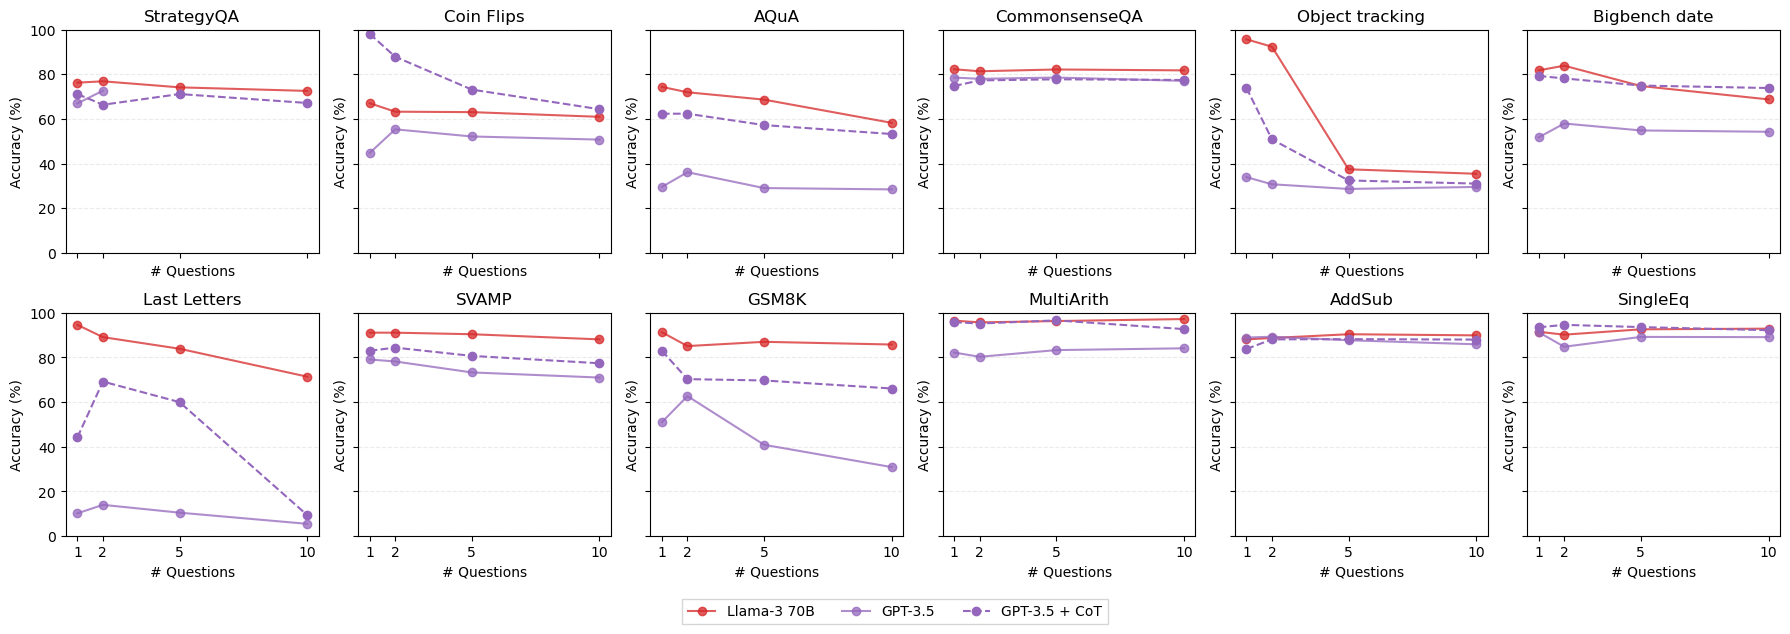

In [13]:
import matplotlib.pyplot as plt

colors = ["black", "tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]
models = ["Overall", "Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

colorMap = dict(zip(models, colors))
colorMap["GPT-3.5 + CoT"] = colorMap["GPT-3.5"]
models = ["Llama-3 70B", "GPT-3.5", "GPT-3.5 + CoT"]

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharex=True, sharey=True)
reasoning_benchmarks = ["strategyqa", "coin_flip", "aqua", "commonsensqa", 
                        "object_tracking", "bigbench_date", "last_letters", 
                        "svamp", "gsm8k", "multiarith", "addsub", "singleeq"]


for i, benchmark in enumerate(reasoning_benchmarks):
    sub = accu_df.copy()[accu_df.benchmark == benchmark]
    ax = axes[i//6, i%6]

    for model in models:
        accus = []
        subsub = sub.copy()[sub.model == model]
        qsizes = sorted(subsub.qsize.unique())

        for qsize in qsizes:
            accu = subsub[subsub.qsize == qsize]["accuracy"].values[0]
            accus.append(round(accu, 3) * 100)
        
        if "CoT" not in model:
            linestyle = "-"
            alpha = 0.75
        else:
            linestyle = "--"
            alpha = 1

        ax.plot(qsizes, accus, label=model, color=colorMap[model], 
                    marker='o', linestyle=linestyle, alpha=alpha)
        
        ax.set_title(benchmark_name_map[benchmark])
        ax.set_xlabel("# Questions")
        ax.set_xticks(qsizes)
        ax.set_ylabel("Accuracy (%)")
        ax.set_ylim(0, 100)
        ax.grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-2.5, -0.25), fancybox=False, shadow=False, ncol=6)
plt.savefig("plots/single-source-reasoning-results.png", bbox_inches='tight', dpi=300)
plt.show()

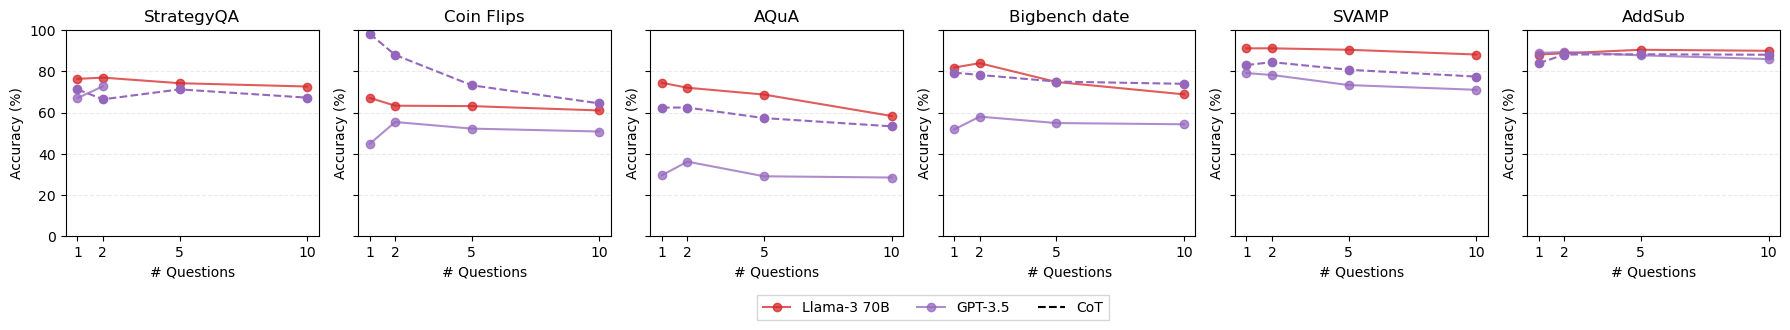

In [23]:
selected_benchmarks = ["commonsensqa", "object_tracking", "last_letters", "gsm8k", "multiarith", "singleeq"]
selected_benchmarks = [b for b in reasoning_benchmarks if b not in selected_benchmarks]
fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharey=True)


for i, benchmark in enumerate(selected_benchmarks):
    sub = accu_df.copy()[accu_df.benchmark == benchmark]
    ax = axes[i]

    for model in models:
        accus = []
        subsub = sub.copy()[sub.model == model]
        qsizes = sorted(subsub.qsize.unique())

        for qsize in qsizes:
            accu = subsub[subsub.qsize == qsize]["accuracy"].values[0]
            accus.append(round(accu, 3) * 100)
        
        if "CoT" not in model:
            alpha = 0.75
            ax.plot(qsizes, accus, label=model, color=colorMap[model], 
                    marker='o', linestyle="-", alpha=alpha)
        else:
            alpha = 1
            ax.plot(qsizes, accus, color=colorMap[model], 
                    marker='o', linestyle="--", alpha=alpha)
        
        
        
        ax.set_title(benchmark_name_map[benchmark])
        ax.set_xlabel("# Questions")
        ax.set_xticks(qsizes)
        ax.set_ylabel("Accuracy (%)")
        ax.set_ylim(0, 100)
        ax.grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.plot([], [], linestyle="--",  color="black", label="CoT", alpha=1)
plt.legend(loc='upper center', bbox_to_anchor=(-2.35, -0.25), fancybox=False, shadow=False, ncol=3)
plt.savefig("plots/more-single-source-reasoning-results.png", bbox_inches='tight', dpi=300)
plt.show()

## mixed-source

In [12]:
r_models

['meta-llama/Llama-3-8b-chat-hf',
 'meta-llama/Llama-3-70b-chat-hf',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'mistralai/Mixtral-8x7B-Instruct-v0.1',
 'lmsys/vicuna-13b-v1.5',
 'gpt-3.5-turbo-0125']

In [42]:
versions = [1, 2, 3, 4, 5, 6]
lengths = [2, 4, 6, 8, 10]
methods = ["zero-shot", "zero-shot-cot"]
tmp = "results/reasoning/mixed/#datasets={}/v#{}/{}.json"
cot_trigger = "\nTherefore, the answers to these questions are as follows:\n"
directAnswerTrigger = "answer is"

models = ["gpt-3.5-turbo-0125", 
         "meta-llama/Llama-3-70b-chat-hf"]

out = []
cols = ["version", "#datasets", "model", "method", "promptIdx", 
        "answers", "preds", "accuracies", "overallAccuracy"]

for v in versions:
    for l in lengths:
        for method in methods:
            input_fp = tmp.format(l, v, method)
            df = pd.read_json(input_fp)

            if not os.path.exists(input_fp):
                continue
        
            try:
                df = pd.read_json(input_fp)

                for model in models:
                    if f"{model}-completion" not in df.columns:
                        continue
                    
                    for ix in df.index:
                        source = df.loc[ix, "source"]
                        answers = df.loc[ix, "answer"]
                        promptIdx = df.loc[ix, "promptIdx"]
                        completion = df.loc[ix, f"{model}-completion"]
                        preds = get_preds(completion, len(source))

                        if not preds:
                            out.append([v, l, model, method, promptIdx, answers, completion, "CANNOT_PARSE", "CANNOT_PARSE"])
                            continue
                        
                        accuracies = dict()
                        
                        for j, pred in enumerate(preds):
                            dataset = source[j][0]
                            # pred = answer_cleansing(pred, method, dataset, directAnswerTrigger)
                            pred = parse(pred, model, dataset, method, cot_trigger)
                            preds[j] = pred
                            answer = answers[j].replace(",", "") if isinstance(answers[j], str) else answers[j]

                            if dataset in ("gsm8k", "addsub", "multiarith", "svamp", "singleeq"):
                                pred = safe_convert_to(float)(pred)
                                answer = safe_convert_to(float)(answer)

                            accuracies[dataset] = float(pred == answer)
                        
                        overall = sum(accuracies.values()) / len(accuracies)
                        out.append([v, l, model, method, promptIdx, answers, preds, accuracies, overall])

            except Exception as e:
                print(e)

In [43]:
out_df = pd.DataFrame(out, columns=cols)
out_df.shape

(27000, 9)

In [44]:
out_df.head()

,version,#datasets,model,method,promptIdx,answers,preds,accuracies,overallAccuracy
0,1,2,gpt-3.5-turbo-0125,zero-shot,1,"[203, no]","[203, no]","{'singleeq': 1.0, 'strategyqa': 1.0}",1.0
1,1,2,gpt-3.5-turbo-0125,zero-shot,2,"[105, no]","[105, no]","{'singleeq': 1.0, 'strategyqa': 1.0}",1.0
2,1,2,gpt-3.5-turbo-0125,zero-shot,3,"[yes, 21]","[yes, 21]","{'strategyqa': 1.0, 'singleeq': 1.0}",1.0
3,1,2,gpt-3.5-turbo-0125,zero-shot,4,"[441, no]","[441, CANNOT_PARSE]","{'singleeq': 1.0, 'strategyqa': 0.0}",0.5
4,1,2,gpt-3.5-turbo-0125,zero-shot,5,"[no, 326]","[no, 326]","{'strategyqa': 1.0, 'singleeq': 1.0}",1.0


In [45]:
out_df.model = out_df.model.map(model_renamer)
out_df.model.value_counts()

GPT-3.5        18000
Llama-3 70B     9000
Name: model, dtype: int64

In [46]:
out_df[out_df["overallAccuracy"] == "CANNOT_PARSE"].shape

(70, 9)

In [47]:
baselines = accu_df.copy()[accu_df.qsize == 1].reset_index(drop=True)

def get_baseline(dataset, method, model):
    return baselines[(baselines["benchmark"] == dataset) & 
          (baselines["method"] == method) & 
          (baselines["model"] == model)]["accuracy"].values[0]

def get_expected_baseline(datasets, method, model):
    return sum([get_baseline(dataset, method, model) for dataset in datasets]) / len(datasets)

In [28]:
colors = ["black", "tab:brown", "tab:pink",  
          "tab:green", "tab:orange", "tab:red", "tab:purple", "tab:blue",
          "tab:olive", "tab:cyan", "tab:gray"]
models = ["Overall", "Vicuna 13B", "Mistral 7B", "Mixtral 8x7B", 
          "Llama-3 8B", "Llama-3 70B", "GPT-3.5", "GPT-4"]

colorMap = dict(zip(models, colors))
colorMap["GPT-3.5 + CoT"] = colorMap["GPT-3.5"]
colorMap

{'Overall': 'black',
 'Vicuna 13B': 'tab:brown',
 'Mistral 7B': 'tab:pink',
 'Mixtral 8x7B': 'tab:green',
 'Llama-3 8B': 'tab:orange',
 'Llama-3 70B': 'tab:red',
 'GPT-3.5': 'tab:purple',
 'GPT-4': 'tab:blue',
 'GPT-3.5 + CoT': 'tab:purple'}

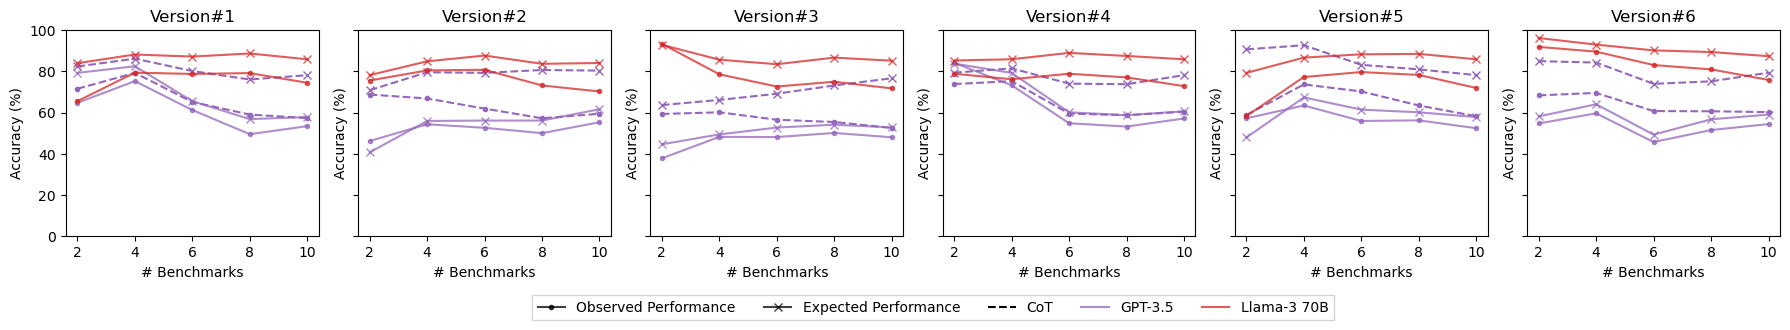

In [201]:
from scripts.utils import *
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 6, figsize=(18, 3), sharey=True)

# plt.subplots_adjust(hspace=0.5)
# plt.subplots_adjust(wspace=0.5)

versions = [1, 2, 3, 4, 5, 6]
ds_nums = [2, 4, 6, 8, 10]
methods_map = {"zero-shot": "-", "zero-shot-cot": "--"}

for i, v in enumerate(versions):
    ax = axs[i]
    
    for model in ["GPT-3.5","Llama-3 70B"]:
        for method in methods:

            accus = []
            expected = []

            sub = out_df.copy()[(out_df["version"] == v) & 
                                (out_df["model"] == model) &
                                (out_df["method"] == method) & 
                                (out_df["overallAccuracy"] != "CANNOT_PARSE")]
            
            if len(sub) == 0:
                continue

            if model == "GPT-3.5" and method == "zero-shot-cot":
                model = "GPT-3.5 + CoT"

            for ds_num in ds_nums:
                accu = sub[sub["#datasets"] == ds_num]["overallAccuracy"].mean()
                accus.append(round(accu, 3) * 100)
                dataset_names = read_obj_from_pickle(f"data/databases/reasoning/mixed/database_{ds_num}.pkl", False)[f"v#{v}"]["datasets"]
                e = get_expected_baseline(dataset_names, method, model)
                expected.append(round(e, 3) * 100)
            
            if not "CoT" in model:
                alpha = 0.75
            else:
                alpha = 1

            ax.plot(ds_nums, accus, marker='.', linestyle=methods_map[method], 
                    color=colorMap[model], alpha=alpha)
            ax.plot(ds_nums, expected, marker='x', linestyle=methods_map[method], 
                    color=colorMap[model], alpha=alpha)
        
        ax.set_title(f"Version#{v}")
        ax.set_xlabel("# Benchmarks")
        ax.set_ylabel("Accuracy (%)")
        ax.set_xticks(ds_nums)
        ax.set_ylim(0, 100)

plt.plot([], [], marker='.', linestyle="-", color="black", label="Observed Performance", alpha=0.75)
plt.plot([], [], marker='x', linestyle="-", color="black", label="Expected Performance", alpha=0.75)
plt.plot([], [], linestyle="--",  color="black", label="CoT", alpha=1)
plt.plot([], [],  linestyle="-", color=colorMap["GPT-3.5"], label="GPT-3.5", alpha=0.75)
plt.plot([], [],  linestyle="-", color=colorMap["Llama-3 70B"], label="Llama-3 70B", alpha=0.75)

plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-2.35, -0.25), fancybox=False, shadow=False, ncol=5)
plt.savefig("plots/mixed-source-reasoning-results.png", bbox_inches='tight', dpi=300)
plt.show()

## Error rate across benchmarks under multiple problems

In [48]:
out_df.head()

,version,#datasets,model,method,promptIdx,answers,preds,accuracies,overallAccuracy
0,1,2,GPT-3.5,zero-shot,1,"[203, no]","[203, no]","{'singleeq': 1.0, 'strategyqa': 1.0}",1.0
1,1,2,GPT-3.5,zero-shot,2,"[105, no]","[105, no]","{'singleeq': 1.0, 'strategyqa': 1.0}",1.0
2,1,2,GPT-3.5,zero-shot,3,"[yes, 21]","[yes, 21]","{'strategyqa': 1.0, 'singleeq': 1.0}",1.0
3,1,2,GPT-3.5,zero-shot,4,"[441, no]","[441, CANNOT_PARSE]","{'singleeq': 1.0, 'strategyqa': 0.0}",0.5
4,1,2,GPT-3.5,zero-shot,5,"[no, 326]","[no, 326]","{'strategyqa': 1.0, 'singleeq': 1.0}",1.0


In [75]:
errors = []
models = ['GPT-3.5', 'Llama-3 70B']
cols = ["version", "#datasets", "model", "method", "benchmark", "observed", "expected"]

for v in versions:
    for l in lengths:
        for method in methods:
            for model in models:
                sub = out_df.copy()[(out_df["version"] == v) & 
                                    (out_df["#datasets"] == l) & 
                                    (out_df["model"] == model) & 
                                    (out_df["method"] == method) & 
                                    (out_df["overallAccuracy"] != "CANNOT_PARSE")]
                
                if len(sub) == 0:
                    continue

                benchmarks = list(sub.accuracies.values[0].keys())
                for benchmark in benchmarks:
                    accs = [s[benchmark] for s in sub.accuracies]
                    observed = sum(accs) / len(accs)

                    if "cot" in method:
                        model = "GPT-3.5 + CoT"
                    expected = get_expected_baseline([benchmark], method, model)
                    errors.append([v, l, model, method, benchmark, observed, expected])

errors_df = pd.DataFrame(errors, columns=cols)
errors_df.head()

,version,#datasets,model,method,benchmark,observed,expected
0,1,2,GPT-3.5,zero-shot,singleeq,0.866667,0.913386
1,1,2,GPT-3.5,zero-shot,strategyqa,0.426667,0.670399
2,1,2,Llama-3 70B,zero-shot,singleeq,0.865320,0.915354
3,1,2,Llama-3 70B,zero-shot,strategyqa,0.444444,0.762877
4,1,2,GPT-3.5 + CoT,zero-shot-cot,singleeq,0.926667,0.935039


In [97]:
diffs = errors_df["observed"] - errors_df["expected"]
diffs[diffs >= 0].describe().round(3) * 100

count    9900.0
mean        2.9
std         2.5
min         0.1
25%         1.1
50%         2.6
75%         4.2
max        13.9
dtype: float64

In [98]:
(diffs >= 0).mean().round(3) * 100

18.3

In [99]:
len(errors_df)

540

In [102]:
errors_df

,version,#datasets,model,method,benchmark,observed,expected
0,1,2,GPT-3.5,zero-shot,singleeq,0.866667,0.913386
1,1,2,GPT-3.5,zero-shot,strategyqa,0.426667,0.670399
2,1,2,Llama-3 70B,zero-shot,singleeq,0.865320,0.915354
3,1,2,Llama-3 70B,zero-shot,strategyqa,0.444444,0.762877
4,1,2,GPT-3.5 + CoT,zero-shot-cot,singleeq,0.926667,0.935039
...,...,...,...,...,...,...,...
535,6,10,GPT-3.5 + CoT,zero-shot-cot,multiarith,0.903333,0.958333
536,6,10,GPT-3.5 + CoT,zero-shot-cot,gsm8k,0.483333,0.830174
537,6,10,GPT-3.5 + CoT,zero-shot-cot,commonsensqa,0.670000,0.748148
538,6,10,GPT-3.5 + CoT,zero-shot-cot,coin_flip,0.493333,0.982000


In [109]:
errors_df[errors_df.model == "GPT-3.5"]

,version,#datasets,model,method,benchmark,observed,expected
0,1,2,GPT-3.5,zero-shot,singleeq,0.866667,0.913386
1,1,2,GPT-3.5,zero-shot,strategyqa,0.426667,0.670399
6,1,4,GPT-3.5,zero-shot,multiarith,0.816667,0.821667
7,1,4,GPT-3.5,zero-shot,addsub,0.840000,0.888608
8,1,4,GPT-3.5,zero-shot,singleeq,0.883333,0.913386
...,...,...,...,...,...,...,...
515,6,10,GPT-3.5,zero-shot,multiarith,0.823333,0.821667
516,6,10,GPT-3.5,zero-shot,gsm8k,0.286667,0.510235
517,6,10,GPT-3.5,zero-shot,commonsensqa,0.723333,0.786066
518,6,10,GPT-3.5,zero-shot,coin_flip,0.490000,0.448000


In [106]:
# model, method, benchmark 


1080

In [88]:
errors_df[diffs >= 0].model.value_counts()

GPT-3.5          47
Llama-3 70B      30
GPT-3.5 + CoT    22
Name: model, dtype: int64

In [92]:
errors_df.benchmark.value_counts()

multiarith         57
object_tracking    54
aqua               54
addsub             51
last_letters       48
gsm8k              48
singleeq           45
strategyqa         45
commonsensqa       45
svamp              36
coin_flip          33
bigbench_date      24
Name: benchmark, dtype: int64

In [94]:
34 / 51

0.6666666666666666

In [91]:
errors_df[diffs >= 0].benchmark.value_counts()

addsub             34
multiarith         16
singleeq           11
coin_flip          11
aqua               11
bigbench_date       7
object_tracking     3
svamp               3
last_letters        2
gsm8k               1
Name: benchmark, dtype: int64

In [93]:
errors_df[diffs < 0].benchmark.value_counts()

object_tracking    51
gsm8k              47
last_letters       46
strategyqa         45
commonsensqa       45
aqua               43
multiarith         41
singleeq           34
svamp              33
coin_flip          22
addsub             17
bigbench_date      17
Name: benchmark, dtype: int64

In [96]:
diffs[diffs < 0].describe().round(3) * 100

count    44100.0
mean       -13.5
std         12.7
min        -60.2
25%        -20.6
50%         -9.4
75%         -3.8
max         -0.1
dtype: float64

In [90]:
errors_df[diffs < 0].model.value_counts()

GPT-3.5 + CoT    158
Llama-3 70B      150
GPT-3.5          133
Name: model, dtype: int64

In [81]:
sub = errors_df[(errors_df["model"] == "GPT-3.5") & 
                (errors_df["method"] == "zero-shot") & 
                (errors_df["benchmark"] == "strategyqa")]

(sub["observed"] - sub["expected"])

1     -0.243732
9     -0.200399
22    -0.160399
41    -0.133486
66    -0.093732
129   -0.138626
154   -0.150264
200   -0.168726
218   -0.173732
242   -0.155348
277   -0.197065
289   -0.167065
309   -0.147065
334   -0.153732
429   -0.150399
dtype: float64

## Reasoning results all in one

In [154]:
reasoning_benchmarks 

['strategyqa',
 'coin_flip',
 'aqua',
 'commonsensqa',
 'object_tracking',
 'bigbench_date',
 'last_letters',
 'svamp',
 'gsm8k',
 'multiarith',
 'addsub',
 'singleeq']

In [165]:
qsizes

[1, 2, 5, 10]

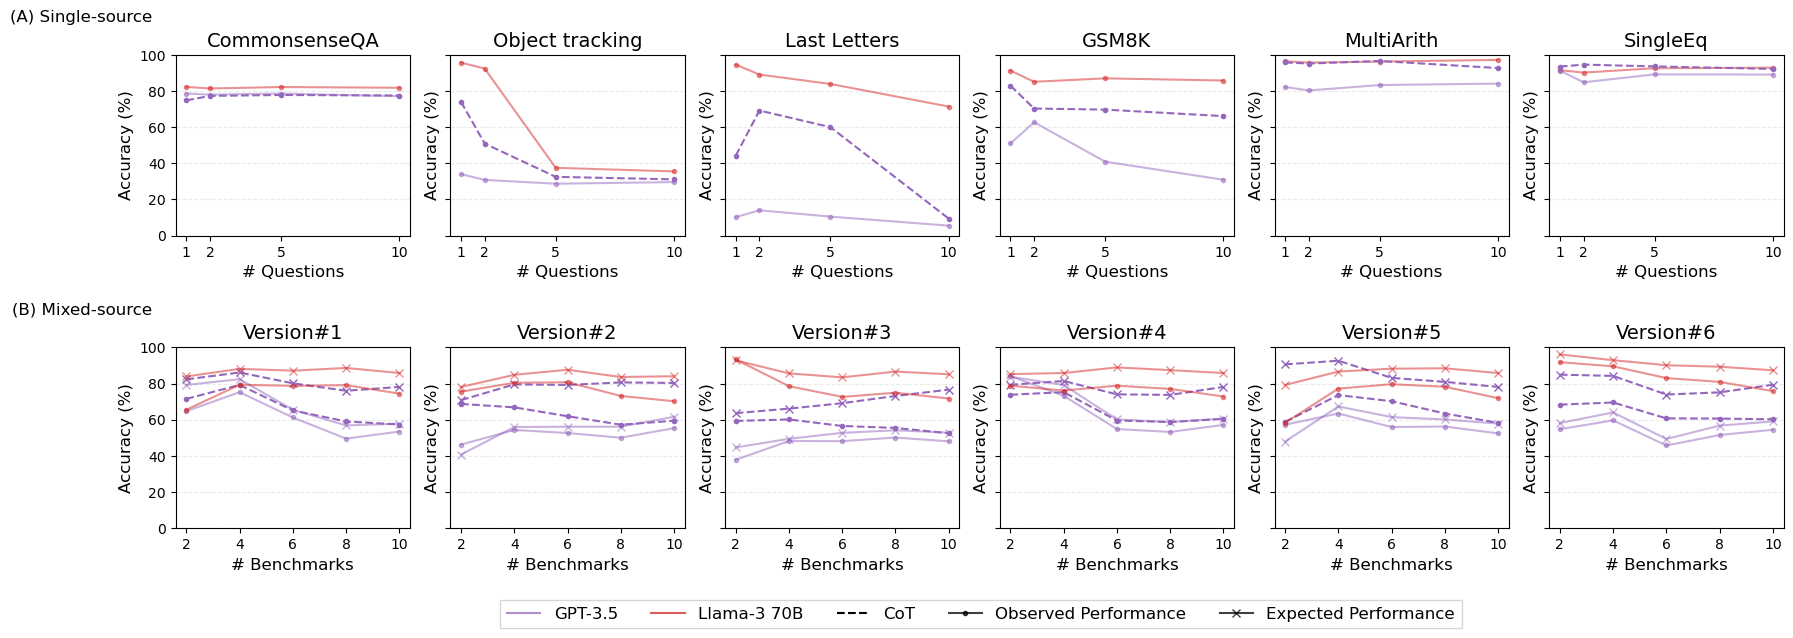

In [212]:
selected_benchmarks = ["commonsensqa", "object_tracking", "last_letters", "gsm8k", "multiarith", "singleeq"]
fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey=True)

for i, benchmark in enumerate(selected_benchmarks):
    sub = accu_df.copy()[accu_df.benchmark == benchmark]
    up_ax = axes[0, i]

    for model in ['Llama-3 70B', 'GPT-3.5', 'GPT-3.5 + CoT']:
        accus = []
        subsub = sub.copy()[sub.model == model]
        qsizes = sorted(subsub.qsize.unique())

        for qsize in [1, 2, 5, 10]:
            accu = subsub[subsub.qsize == qsize]["accuracy"].values[0]
            accus.append(round(accu, 3) * 100)
        
        if "CoT" not in model:
            linestyle = "-"
            alpha = 0.5
        else:
            linestyle = "--"
            alpha = 1
            model = "GPT-3.5"

        up_ax.plot(qsizes, accus, label=model, color=colorMap[model], 
                    marker='.', linestyle=linestyle, alpha=alpha)
        
        up_ax.set_title(benchmark_name_map[benchmark], fontsize=14)
        up_ax.set_xlabel("# Questions", fontsize=12)
        up_ax.set_xticks(qsizes)
        up_ax.set_ylabel("Accuracy (%)", fontsize=12)
        up_ax.set_ylim(0, 100)
        up_ax.grid(axis='y', linestyle='--', alpha=0.25)
    
    if i == 0:
        up_ax.text(-0.1, 1.25, "(A) Single-source", transform=up_ax.transAxes, 
                fontsize=12, va='top', ha='right')
        

versions = [1, 2, 3, 4, 5, 6]
ds_nums = [2, 4, 6, 8, 10]
methods_map = {"zero-shot": "-", "zero-shot-cot": "--"}

for j, v in enumerate(versions):
    down_ax = axes[1, j]
    
    for model in ["GPT-3.5","Llama-3 70B"]:
        for method in methods:

            accus = []
            expected = []

            sub = out_df.copy()[(out_df["version"] == v) & 
                                (out_df["model"] == model) &
                                (out_df["method"] == method) & 
                                (out_df["overallAccuracy"] != "CANNOT_PARSE")]
            
            if len(sub) == 0:
                continue

            if model == "GPT-3.5" and method == "zero-shot-cot":
                model = "GPT-3.5 + CoT"

            for ds_num in ds_nums:
                accu = sub[sub["#datasets"] == ds_num]["overallAccuracy"].mean()
                accus.append(round(accu, 3) * 100)
                dataset_names = read_obj_from_pickle(f"data/databases/reasoning/mixed/database_{ds_num}.pkl", False)[f"v#{v}"]["datasets"]
                e = get_expected_baseline(dataset_names, method, model)
                expected.append(round(e, 3) * 100)
            
            if not "CoT" in model:
                alpha = 0.5
            else:
                alpha = 1

            down_ax.plot(ds_nums, accus, marker='.', linestyle=methods_map[method], 
                    color=colorMap[model], alpha=alpha)
            down_ax.plot(ds_nums, expected, marker='x', linestyle=methods_map[method], 
                    color=colorMap[model], alpha=alpha)
        
        down_ax.set_title(f"Version#{v}", fontsize=14)
        down_ax.set_xlabel("# Benchmarks", fontsize=12)
        down_ax.set_ylabel("Accuracy (%)", fontsize=12)
        down_ax.set_xticks(ds_nums)
        down_ax.set_ylim(0, 100)
        down_ax.grid(axis='y', linestyle='--', alpha=0.25)
    
    if j == 0:
        down_ax.text(-0.1, 1.25, "(B) Mixed-source", transform=down_ax.transAxes, 
                fontsize=12, va='top', ha='right')

plt.plot([], [],  linestyle="-", color=colorMap["GPT-3.5"], label="GPT-3.5", alpha=0.75)
plt.plot([], [],  linestyle="-", color=colorMap["Llama-3 70B"], label="Llama-3 70B", alpha=0.75)
plt.plot([], [], linestyle="--",  color="black", label="CoT", alpha=1)
plt.plot([], [], marker='.', linestyle="-", color="black", label="Observed Performance", alpha=0.75)
plt.plot([], [], marker='x', linestyle="-", color="black", label="Expected Performance", alpha=0.75)

plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-2.425, -0.35), fontsize=12, fancybox=False, shadow=False, ncol=5)
plt.savefig("plots/reasoning-results.png", bbox_inches='tight', dpi=300)
plt.show()